In [81]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread("./input/demo.png")
print(type(img))
print(img.shape)
img_height,img_width,img_channels=img.shape

<class 'numpy.ndarray'>
(512, 512, 3)


加噪声代码

In [82]:
mean = 0#均值
sigma = 25#方差
gauss = np.random.normal(mean,sigma,(img_height,img_width,img_channels))#获取高斯噪声
noisy_img = img + gauss#叠加
noisy_img = np.clip(noisy_img,a_min=0,a_max=255).astype(np.uint8)
cv2.imwrite("noisy_img.png",noisy_img)

# 保存含噪声的图像
cv2.imwrite("./output/noisy_img.png", noisy_img)

True

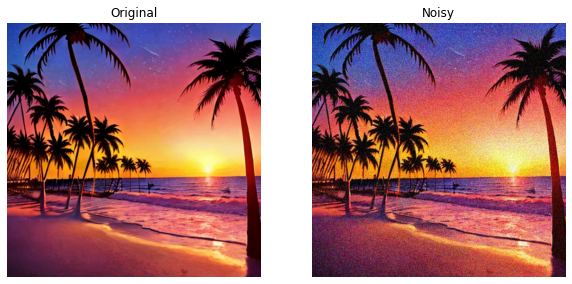

In [83]:
# 将 BGR 图像转换为 RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
noisy_img_rgb = cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB)

# 显示原始图像
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title('Original')
plt.axis('off')  # 隐藏坐标轴

# 显示含噪声图像
plt.subplot(1, 2, 2)
plt.imshow(noisy_img_rgb)
plt.title('Noisy')
plt.axis('off')  # 隐藏坐标轴

plt.show()

加雨雾

In [84]:
import os
import random
import torch
mask_img=torch.zeros(img_height,img_width,img_channels).numpy()
mask_img[:, :] = (220, 220, 220)#灰度图片
image = cv2.addWeighted(img, round(random.uniform(0.5, 0.5), 2), img, 1, 0)  # 里面参数可调，主要调整雾的浓度（0.1， 0.1）这两个参数控制雾的浓度，多调整下就懂了
cv2.imwrite('./output/rain_img.jpg', image) # 保存文件，图片名称和输入的相同，可以自己设置更改


True

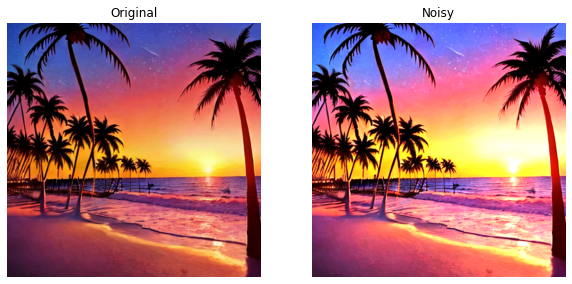

In [85]:
# 将 BGR 图像转换为 RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 显示原始图像
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title('Original')
plt.axis('off')  # 隐藏坐标轴

# 显示含噪声图像
plt.subplot(1, 2, 2)
plt.imshow(image_rgb)
plt.title('Noisy')
plt.axis('off')  # 隐藏坐标轴

plt.show()

去雾

In [86]:
import cv2
import math
import numpy as np

def DarkChannel(im,sz):
    b,g,r = cv2.split(im)#获取各通道数组
    dc = cv2.min(cv2.min(r,g),b);#获取三通道中最暗的
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(sz,sz))#创建腐蚀矩形核
    dark = cv2.erode(dc,kernel)#减少亮区域
    return dark

def AtmLight(im,dark):#估计图像的全局大气光照
    [h,w] = im.shape[:2]
    imsz = h*w
    numpx = int(max(math.floor(imsz/1000),1))#计算用于估计大气光照的像素数量
    darkvec = dark.reshape(imsz);
    imvec = im.reshape(imsz,3);#打平图像

    indices = darkvec.argsort();#获得排序索引
    indices = indices[imsz-numpx::]#倒数第 imsz-numpx 个元素开始直到数组末尾的元素。

    atmsum = np.zeros([1,3])
    for ind in range(1,numpx):
       atmsum = atmsum + imvec[indices[ind]]

    A = atmsum / numpx;
    return A

def TransmissionEstimate(im,A,sz):#估计图像的传输率
    omega = 0.95;
    im3 = np.empty(im.shape,im.dtype);

    for ind in range(0,3):
        im3[:,:,ind] = im[:,:,ind]/A[0,ind]#标准化每个通道

    transmission = 1 - omega*DarkChannel(im3,sz);#计算传输率
    return transmission

def Guidedfilter(im,p,r,eps):#滤波函数
    mean_I = cv2.boxFilter(im,cv2.CV_64F,(r,r));
    mean_p = cv2.boxFilter(p, cv2.CV_64F,(r,r));
    mean_Ip = cv2.boxFilter(im*p,cv2.CV_64F,(r,r));
    cov_Ip = mean_Ip - mean_I*mean_p;

    mean_II = cv2.boxFilter(im*im,cv2.CV_64F,(r,r));
    var_I   = mean_II - mean_I*mean_I;

    a = cov_Ip/(var_I + eps);
    b = mean_p - a*mean_I;

    mean_a = cv2.boxFilter(a,cv2.CV_64F,(r,r));
    mean_b = cv2.boxFilter(b,cv2.CV_64F,(r,r));

    q = mean_a*im + mean_b;
    return q;

def TransmissionRefine(im,et):#细化传输率
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY);
    gray = np.float64(gray)/255;
    r = 60;
    eps = 0.0001;
    t = Guidedfilter(gray,et,r,eps);

    return t;

def Recover(im,t,A,tx = 0.1):#复原函数
    res = np.empty(im.shape,im.dtype);
    t = cv2.max(t,tx);

    for ind in range(0,3):
        res[:,:,ind] = (im[:,:,ind]-A[0,ind])/t + A[0,ind]

    return res

if __name__ == '__main__':
    import sys
    
    fn = './output/rain_img.jpg'

    def nothing(*argv):
        pass

    src = cv2.imread(fn);

    I = src.astype('float64')/255;
 
    dark = DarkChannel(I,15);
    A = AtmLight(I,dark);
    te = TransmissionEstimate(I,A,15);
    t = TransmissionRefine(src,te);
    J = Recover(I,t,A,0.1);

    cv2.imshow("dark",dark);
    cv2.imshow("t",t);
    cv2.imshow('I',src);
    cv2.imshow('J',J);
    cv2.imwrite("./image/J.png",J*255);
    cv2.waitKey();